# 0. Resumo

O presente trabalho buscou identificar possíveis indícios de correlação entre as taxas de óbitos em decorrência da covid-19 por 100 mil habitantes, para cada UF, em relação à 3 indicadores: 

* Valor gasto por habitante em despesas hospitales do SUS nos últimos 2 anos (considerando que mais de 70% da população brasileira é dependente da saúde pública);



* Índice de Gini, que mede a desigualdade de renda da população;



* Densidade demográfica, que é um índice demográfico que calcula o número de habitantes por quilômetro quadrado.


Foram encontradas possíveis correlações para os 3 indicadores estudados e, por consequência, foram sugeridos trabalhos futuros para buscar aprofundar o conhecimento das relações destes indicadores com a taxa de mortalidade por covid-19.

# 1. Setup

## 1.1 Bibiliotecas usadas

In [4]:
### Importar bibliotecas que será utilizadas na análise:
# Bibliotecas numéricas e de dados
import pandas as pd
import numpy as np
import json
import missingno as msno # biblioteca utilizada para identificar os dados NaN

# Para ler a base do IBGE (índice de Gini)
# É necessário instalar a biblioteca pandas_ods_reader para ler os dados do IBGE
#!pip install -q pandas_ods_reader  
from pandas_ods_reader import read_ods

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.patches import Rectangle


## 1.2 Leitura dos dados do Brasil_IO

In [77]:
# Carregar fonte do Brasil.io
#fonte_brasil_io_caso = '/content/drive/My Drive/data_science_files/brasil_io/caso.csv.gz'
fonte_brasil_io_caso = 'data/caso.csv.gz'
covid19_brasil_io_original = pd.read_csv(fonte_brasil_io_caso, compression='gzip')
covid19_brasil_io_original.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-11-14,AP,NaN,state,54838,777,235,True,845731.0,861773.0,16.0,6363.39268,0.0142
1,2020-11-13,AP,NaN,state,54417,774,234,False,845731.0,861773.0,16.0,6314.53991,0.0142
2,2020-11-12,AP,NaN,state,54056,771,233,False,845731.0,861773.0,16.0,6272.64953,0.0143
3,2020-11-11,AP,NaN,state,53790,770,232,False,845731.0,861773.0,16.0,6241.78293,0.0143
4,2020-11-10,AP,NaN,state,53574,766,231,False,845731.0,861773.0,16.0,6216.71832,0.0143


## 1.3 Leitura dos dados do IBGE (Índice de Gini)


In [7]:
#path = '/content/drive/My Drive/kaggle/PNAD_Continua_2019_Rendimento_de_Todas_as_Fontes.ods'
path = 'data/PNAD_Continua_2019_Rendimento_de_Todas_as_Fontes.ods'
sheet_name = "Trab_hab_Outros_efetivo"
df_ibge_gini = read_ods(path, sheet_name)

df_ibge_gini.head()

,csas,Nivel_territorial,Abertura_geografica,Tipo,ind,classe,sub_classe,Unid,2012,2013,2014,2015,2016,2017,2018,2019
0,10110001,País,Brasil,Valor,"População residente, com rendimento",Tipo de Rendimento,Todas as fontes¹,(1 000 pessoas),119957.0,121765.0,123863.0,124710.0,124992.0,125784.0,128257.0,131229.0
1,10110002,País,Brasil,Valor,"População residente, com rendimento",Tipo de Rendimento,Todos os trabalhos¹,(1 000 pessoas),86142.0,87640.0,89007.0,89390.0,88469.0,88777.0,90116.0,92458.0
2,10110003,País,Brasil,Valor,"População residente, com rendimento",Tipo de Rendimento,Outras fontes,(1 000 pessoas),46632.0,46938.0,47254.0,47850.0,49038.0,49697.0,51751.0,52682.0
3,10110004,País,Brasil,Valor,"População residente, com rendimento",Tipo de Rendimento,Aposentadoria e pensão,(1 000 pessoas),25820.0,25974.0,27065.0,27356.0,28449.0,29021.0,30448.0,30734.0
4,10110005,País,Brasil,Valor,"População residente, com rendimento",Tipo de Rendimento,Aluguel e arrendamento,(1 000 pessoas),3474.0,3409.0,3164.0,3461.0,3686.0,3949.0,4263.0,4468.0


In [78]:
# Capturar apenas os dados do índice de Gini por estado
df_gini = df_ibge_gini.query("classe=='Gini'")
df_gini_por_Estado = df_gini.query("Nivel_territorial=='Unidade da Federação' & ind == 'Índice de Gini do rendimento médio mensal real das pessoas de 14 anos ou mais de idade, em todos os trabalhos, a preços médios do ano' & \
Tipo == 'Valor'")

# A linha abaixa evita um warning chato
pd.options.mode.chained_assignment = None

# Tratar os nomes dos estados dos dados (IBGE fornece os nomes dos Estados por extenso)
dic = {"Acre": "AC", "Alagoas": "AL", "Amapá": "AP","Amazonas":"AM", "Bahia":"BA", "Ceará":"CE", "Distrito Federal":"DF", "Espirito Santo":"ES", "Goiás":"GO", \
      "Maranhão":"MA","Mato Grosso":"MT","Mato Grosso do Sul":"MS","Minas Gerais":"MG","Pará":"PA","Paraíba":"PB","Paraná":"PR","Pernambuco":"PE", "Piauí":"PI", \
      "Rio de Janeiro":"RJ","Rio Grande do Norte":"RN","Rio Grande do Sul":"RS","Rondônia":"RO","Roraima":"RR","Santa Catarina":"SC","São Paulo":"SP", \
      "Sergipe":"SE","Tocantins":"TO"}
df_gini_por_Estado['Abertura_geografica'].replace(dic, inplace=True)


# Realizar novo filtro no df do índice de Gini, dessa vez para capturar apenas as colunas necessárias na análise.
# Além disso, alterar o índice do df para o estado.
df_gini_por_Estado = df_gini_por_Estado[["Abertura_geografica","2012","2013","2014","2015","2016","2017","2018","2019"]]
df_gini_por_Estado.set_index("Abertura_geografica",inplace=True, drop=True)

# Ordem do índice Gini acumulado de 2012 a 2019
# Variável é usada posteriormente
ordem_soma_gini = df_gini_por_Estado.sum(axis=1).sort_values()

# Transformando a series do índice de Gini em df e já alterando o índice para 
# 'state' e assim poder efetuar o merge com o df do último boletim
indice_Gini_UF = pd.DataFrame({'state':ordem_soma_gini.index, 'indice_Gini':ordem_soma_gini.values}).set_index('state')

indice_Gini_UF.head()

,indice_Gini
state,
SC,3.230
RO,3.501
MT,3.522
GO,3.538
AL,3.634


## 1.4 Leitura dos dados do Data SUS (gastos hospitalares)

In [79]:
fonte = 'https://raw.githubusercontent.com/alura-cursos/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv' #por atendimento

db = pd.read_csv(fonte, encoding='latin1', skiprows =3, sep = ";", skipfooter=12, thousands=".", decimal=",", engine = 'python')

#localizando as colunas não numéricas
db.select_dtypes(exclude=np.number)

# Há muitas colunas que possuem "-", que descaracteriza a coluna como sendo numérica.
colunas_usaveis = db.mean().index.tolist()

#Importante adicionar a coluna "Unidade da Federação" para continuar exibindo os valores por UF.
colunas_usaveis.insert(0,"Unidade da Federação")
colunas_usaveis

# Efetuo um slice do meu db apenas com as colunas que contém puramente números e removo a coluna Total
usaveis = db[colunas_usaveis]
usaveis = usaveis.set_index("Unidade da Federação")
usaveis = usaveis.drop("Total", axis = "columns")

#Efetuo um novo slide para pegar os dados dos últimos 2 anos
gastos_SUS_2019_2020 = usaveis
lista_ultimos_2_anos = gastos_SUS_2019_2020.columns[132:156].tolist()
gastos_SUS_2019_2020 = gastos_SUS_2019_2020[lista_ultimos_2_anos]
gastos_SUS_2019_2020.head()

# Criação de uma coluna chamada "Total"
gastos_SUS_2019_2020["Total"] = gastos_SUS_2019_2020.sum(axis="columns")
gastos_SUS_2019_2020


# Tratar os nomes dos estados dos dados (IBGE fornece os nomes dos Estados por extenso)
dic = {"12 Acre": "AC", "27 Alagoas": "AL", "16 Amapá": "AP","13 Amazonas":"AM", "29 Bahia":"BA", "23 Ceará":"CE", "53 Distrito Federal":"DF", "32 Espírito Santo":"ES", "52 Goiás":"GO", \
      "21 Maranhão":"MA","51 Mato Grosso":"MT","50 Mato Grosso do Sul":"MS","31 Minas Gerais":"MG","15 Pará":"PA","25 Paraíba":"PB","41 Paraná":"PR","26 Pernambuco":"PE", "22 Piauí":"PI", \
      "33 Rio de Janeiro":"RJ","24 Rio Grande do Norte":"RN","43 Rio Grande do Sul":"RS","11 Rondônia":"RO","14 Roraima":"RR","42 Santa Catarina":"SC","35 São Paulo":"SP", \
      "28 Sergipe":"SE","17 Tocantins":"TO"}

gastos_SUS_2019_2020 = gastos_SUS_2019_2020.reset_index(level=['Unidade da Federação'])
gastos_SUS_2019_2020['Unidade da Federação'].replace(dic, inplace=True)
gastos_SUS_2019_2020.set_index('Unidade da Federação',inplace=True, drop=True)
gastos_SUS_2019_2020_series = gastos_SUS_2019_2020['Total']


#Talvez não seja necessário os códigos abaixo
# Ordenação de acordo com as UFs que mais gastam
ordenado_por_total = gastos_SUS_2019_2020.sort_values("Total",ascending=False)
ordenado_por_total_milhoes = ordenado_por_total/1000000 

# Retirar o index e inserí-lo em uma coluna (para facilitar na plot do gráfico)
ordenado_por_total_milhoes.reset_index(inplace=True)

ordenado_por_total_milhoes.head()

,Unidade da Federação,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,...,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,Total
0,SP,295.419311,277.576166,301.454867,278.114302,266.239801,291.081407,267.662509,285.576313,292.584828,...,282.391773,272.697695,301.991168,271.356784,276.606289,251.696363,302.857661,299.060852,282.709570,6893.477908
1,MG,160.420043,145.941008,157.247580,148.172784,145.387241,153.177305,142.669154,151.943631,157.922599,...,152.106660,152.398599,158.097904,141.323176,147.078556,126.330650,136.867276,135.977572,120.467187,3603.232219
2,PR,131.257163,120.647377,129.530164,121.810669,112.984631,124.159240,117.715473,123.907372,127.447034,...,126.209369,113.545319,122.268754,116.061603,114.476998,96.727112,106.103738,92.901461,80.320853,2857.325254
3,RS,96.799643,87.344269,97.371100,90.190768,81.748880,92.467100,85.301000,91.624339,92.787953,...,90.971809,88.720874,97.474363,85.451646,84.651397,76.294597,86.076113,89.019479,78.929704,2181.040582
4,RJ,78.784069,72.837646,79.138171,73.946905,70.688186,79.468379,73.795013,74.919398,76.666971,...,74.620477,74.895862,79.705664,72.412810,73.594498,68.160773,86.281033,77.604925,71.540227,1854.382896


## 1.5 Leitura dos dados do IBGE (densidade demográfica)

In [11]:
# Carregando a base de dados do IBGE da densidade demográfica
path = 'data/densidade_demografica_ibge.ods'
sheet_name = "Worksheet"
df_densidade_demografica_por_Estado = read_ods(path, sheet_name)
df_densidade_demografica_por_Estado.head()

# Tratar os nomes dos estados dos dados (IBGE fornece os nomes dos Estados por extenso)
dic = {"Acre": "AC", "Alagoas": "AL", "Amapá": "AP","Amazonas":"AM", "Bahia":"BA", "Ceará":"CE", "Distrito Federal":"DF", "Espírito Santo":"ES", "Goiás":"GO", \
      "Maranhão":"MA","Mato Grosso":"MT","Mato Grosso do Sul":"MS","Minas Gerais":"MG","Pará":"PA","Paraíba":"PB","Paraná":"PR","Pernambuco":"PE", "Piauí":"PI", \
      "Rio de Janeiro":"RJ","Rio Grande do Norte":"RN","Rio Grande do Sul":"RS","Rondônia":"RO","Roraima":"RR","Santa Catarina":"SC","São Paulo":"SP", \
      "Sergipe":"SE","Tocantins":"TO"}

df_densidade_demografica_por_Estado['UF'].replace(dic, inplace=True)

# Jogando o rodapé da base de dados fora (para ficar apenas com as UFs)
df_densidade_demografica_por_Estado = df_densidade_demografica_por_Estado.head(27)

# Calcular a projeção da densidade demográfica em 2020
df_densidade_demografica_por_Estado['dens_demografica_hab_km2_2020'] = df_densidade_demografica_por_Estado['populacao_estimada_2020']/df_densidade_demografica_por_Estado['area_territorial_km2_2019']

# Ordenar por densidade demografica
df_densidade_demografica_por_Estado = df_densidade_demografica_por_Estado.sort_values('dens_demografica_hab_km2_2020', ascending = False)

# 2. Introdução

Covid-19 é uma doença infecciosa causada pelo coronavírus da síndrome respiratória aguda grave 2. Com forte impacto na saúde das pessoas do mundo todo, a taxa de mortalidade por 100 mil habitantes apresenta diferenças, às vezes significativas, de acordo com a localização. O objetivo deste trabalho é entender melhor estas diferenças para que se possa investigar e atuar na origem delas e, com isso, ocorrer diminuição de vidas perdidas. <br>

O ponto de partida foi utilizar a base de dados da covid-19 da Brasil.IO ("caso.csv") <br>


Começaremos visualizando os primeiros e últimos registros desta base de dados (até o dia 14 de Novembro de 2020) <br>

fonte: https://brasil.io/dataset/covid19/caso/


In [23]:
covid19_brasil_io_original

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-11-14,AP,NaN,state,54838,777,235,True,845731.0,861773.0,16.0,6363.39268,0.0142
1,2020-11-13,AP,NaN,state,54417,774,234,False,845731.0,861773.0,16.0,6314.53991,0.0142
2,2020-11-12,AP,NaN,state,54056,771,233,False,845731.0,861773.0,16.0,6272.64953,0.0143
3,2020-11-11,AP,NaN,state,53790,770,232,False,845731.0,861773.0,16.0,6241.78293,0.0143
4,2020-11-10,AP,NaN,state,53574,766,231,False,845731.0,861773.0,16.0,6216.71832,0.0143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
961798,2020-06-23,SP,Óleo,city,1,0,5,False,2496.0,2471.0,3533809.0,40.46945,0.0000
961799,2020-06-22,SP,Óleo,city,1,0,4,False,2496.0,2471.0,3533809.0,40.46945,0.0000
961800,2020-06-21,SP,Óleo,city,1,0,3,False,2496.0,2471.0,3533809.0,40.46945,0.0000
961801,2020-06-20,SP,Óleo,city,1,0,2,False,2496.0,2471.0,3533809.0,40.46945,0.0000


Devido a presença de códigos NaN, é necessário investigá-los e ver o quanto eles podem estar afetando a base de dados (Figura 1):

<Figure size 432x288 with 0 Axes>

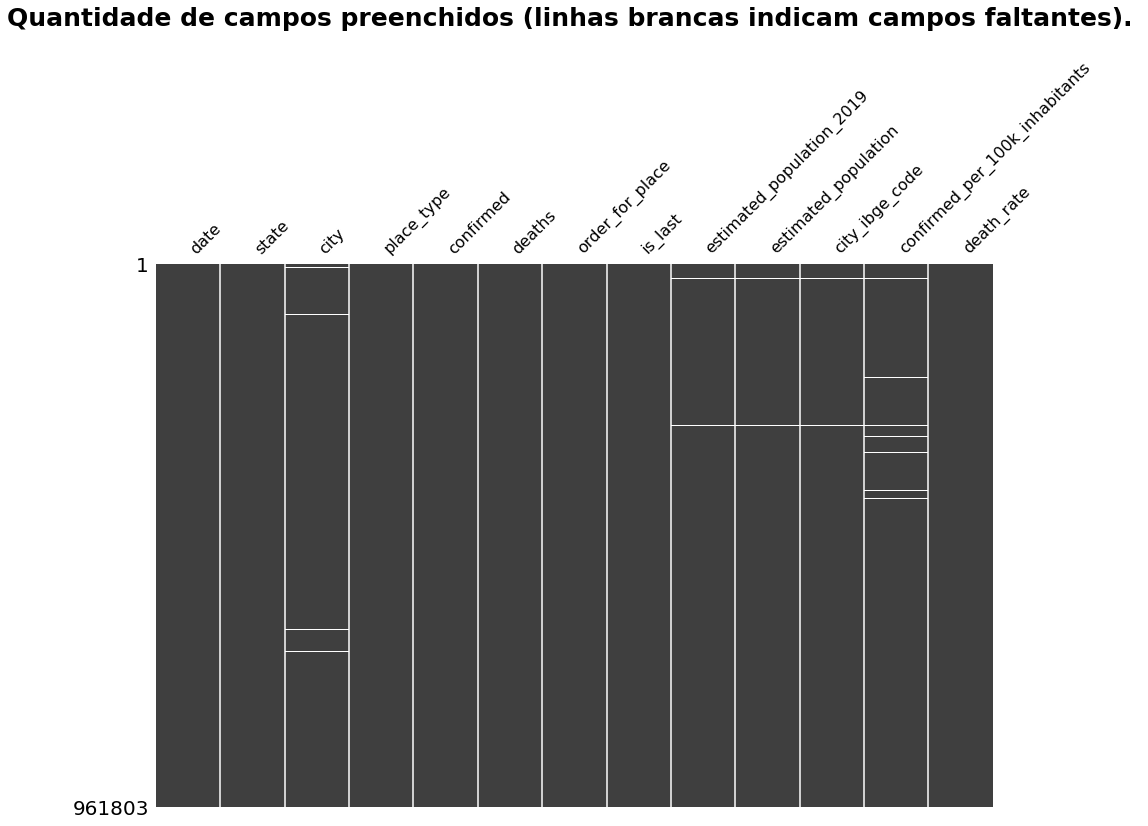

In [37]:
#### Gerar visualização dos valores NaN
plt.figure()
fig, ax1 = plt.subplots(figsize=(15,10))
msno.matrix(covid19_brasil_io_original, ax=ax1, sparkline=False)
plt.title('Quantidade de campos preenchidos (linhas brancas indicam campos faltantes). \n', fontsize=25, fontweight='bold')

plt.show();


Conforme observamos no gráfico, a quantidade de itens faltantes é muito pequena e seus valores não impactarão a análise.

Mas qual seria a quantidade de linhas e percentagem com valores NaN dentre os mais de 1 milhão de registros?

In [45]:
print('Quantidade de linhas faltantes no dataframe: {:{},}'.format(
    covid19_brasil_io_original.shape[0]-covid19_brasil_io_original.dropna().shape[0],6))

print('Porcentagen de linhas faltantes no dataframe: {:{}.2f}%'.format(
      (covid19_brasil_io_original.shape[0]-
       covid19_brasil_io_original.dropna().shape[0]
       )/covid19_brasil_io_original.shape[0]*100,6))


Quantidade de linhas faltantes no dataframe: 23,749
Porcentagen de linhas faltantes no dataframe:   2.47%


Quase 24 mil linhas possuem algum valor NaN, o que representa pouco mais de 2%. A tabela a seguir ajuda a entender em quais colunas estão estas linhas. </font>

In [44]:
with pd.option_context('display.float_format', '{:.2f}%'.format):
    val_NaN = pd.DataFrame()
    val_NaN['Qtd. Linhas Faltantes'] = covid19_brasil_io_original.isnull().sum()
    val_NaN['% Linhas Faltantes'] = round(covid19_brasil_io_original.isnull().sum()/
                                    covid19_brasil_io_original.shape[0]*100,2)
val_NaN

,Qtd. Linhas Faltantes,% Linhas Faltantes
date,0,0.00
state,0,0.00
city,6568,0.68
place_type,0,0.00
confirmed,0,0.00
deaths,0,0.00
order_for_place,0,0.00
is_last,0,0.00
estimated_population_2019,3740,0.39
estimated_population,3740,0.39


Parece que o dataset está muito bom.  <br>
O próximo passo é selecionar as colunas de interesse. Para isso, vamos listar todas as colunas presentes nesta base de dados:

In [28]:
covid19_brasil_io_original.columns

Index(['date', 'state', 'city', 'place_type', 'confirmed', 'deaths',
       'order_for_place', 'is_last', 'estimated_population_2019',
       'estimated_population', 'city_ibge_code',
       'confirmed_per_100k_inhabitants', 'death_rate'],
      dtype='object')

Para a análise de dados, serão utilizadas as colunas:
* 'state': sigla da unidade federativa
* 'place_type': tipo de local que esse registro descreve, pode ser city ou state.
* 'deaths': número de mortes.
* 'is_last': ampo pré-computado que diz se esse registro é o mais novo para esse local, pode ser True ou False
* 'estimated_population': população estimada para esse município/estado em 2020, segundo o IBGE


Conforme a Figura 1 e Tabela 2, dentre as colunas escolhidas, apenas a coluna "estimated_population" apresenta algumas linhas faltantes. Mas como o estudo está focado em UFs, dificilmente alguma delas está sem a informação da população; e caso esteja, pode-se recorrer a outra base.


Vamos verificar o último boletim de óbitos por UF e calcular a taxa por 100 mil habitantes (informações mais atualizadas no dia que a base foi gerada, em 14 de Novembro de 2020):

In [46]:
colunas_de_interesse = ['state','place_type','deaths','is_last',
                        'estimated_population']
covid19_brasil_io = covid19_brasil_io_original[colunas_de_interesse]
ultimo_boletim = covid19_brasil_io.query("is_last == True & place_type == 'state'")

# Mudar o índice do DF ultimo_boletim_ind_UF para 'state' e
# assim poder efetuar o merge com o df que traz o índice de Gini
ultimo_boletim_ind_UF = ultimo_boletim.set_index('state')

# Transformando a series do índice de Gini que foi utilizada para
# criação do gráfico anterior em df e já alterando o índice para 
# 'state' e assim poder efetuar o merge com o df do último boletim
indice_Gini_UF = pd.DataFrame({'state':ordem_soma_gini.index, 'indice_Gini':ordem_soma_gini.values}).set_index('state')

# Merge: índice de Gini ---> último boletim
ultimo_boletim_ind_UF_com_Gini = pd.merge(ultimo_boletim_ind_UF, indice_Gini_UF, left_index=True, right_index=True)

# Transformando a Series
gastos_SUS_2019_2020_Total = pd.DataFrame({'state':gastos_SUS_2019_2020_series.index, 'gastos_SUS':gastos_SUS_2019_2020_series.values}).set_index('state')

# Merge: gastos SUS 2019/2020 ---> último boletim
ultimo_boletim_ind_UF_com_Gini_SUS = pd.merge(ultimo_boletim_ind_UF_com_Gini, gastos_SUS_2019_2020_Total, left_index=True, right_index=True)

# Alterar o índice do df da densidade demográfica do IBGE para poder fazer o merge
df_densidade_demografica_por_Estado_ind_UF = df_densidade_demografica_por_Estado.set_index('UF')

# Separar apenas as colunas de interesse
df_densidade_demografica_por_Estado_ind_UF = df_densidade_demografica_por_Estado_ind_UF[['area_territorial_km2_2019','dens_demografica_hab_km2_2020']]

# Merge: densidade demográfica projeção 2020 ---> último boletim
ultimo_boletim_ind_UF_com_Gini_SUS_dens = pd.merge(ultimo_boletim_ind_UF_com_Gini, df_densidade_demografica_por_Estado_ind_UF, left_index=True, right_index=True)


#df_densidade_demografica_por_Estado['dens_demografica_hab_km2_2020']

ultimo_boletim_ind_UF_com_Gini_SUS_dens['gastos_SUS_por_hab'] = ultimo_boletim_ind_UF_com_Gini_SUS['gastos_SUS']/ultimo_boletim_ind_UF_com_Gini_SUS['estimated_population']
ultimo_boletim_ind_UF_com_Gini_SUS_dens['mortes_100k_hab'] = ultimo_boletim_ind_UF_com_Gini_SUS['deaths']/(ultimo_boletim_ind_UF_com_Gini_SUS['estimated_population']/100000)

ultimo_boletim_ind_UF_com_Gini_SUS_dens[['deaths', 'estimated_population', 'mortes_100k_hab']].sort_index()

,deaths,estimated_population,mortes_100k_hab
AC,708,894470.0,79.153018
AL,2291,3351543.0,68.356575
AM,4693,4207714.0,111.533246
AP,777,861773.0,90.162955
BA,7922,14930634.0,53.058698
CE,9439,9187103.0,102.741855
DF,3813,3055149.0,124.805697
ES,3998,4064052.0,98.374726
GO,6030,7113540.0,84.767921
MA,4171,7114598.0,58.625941


Analisando-se as diferentes UFs, nota-se grandes diferenças nas taxas de óbitos por 100 mil habitantes.

A Figura 2 traz essa informação na forma de gráfico de barros, destacando-se as 10 UFs que apresentam as maiores taxas por 100 mil habitantes


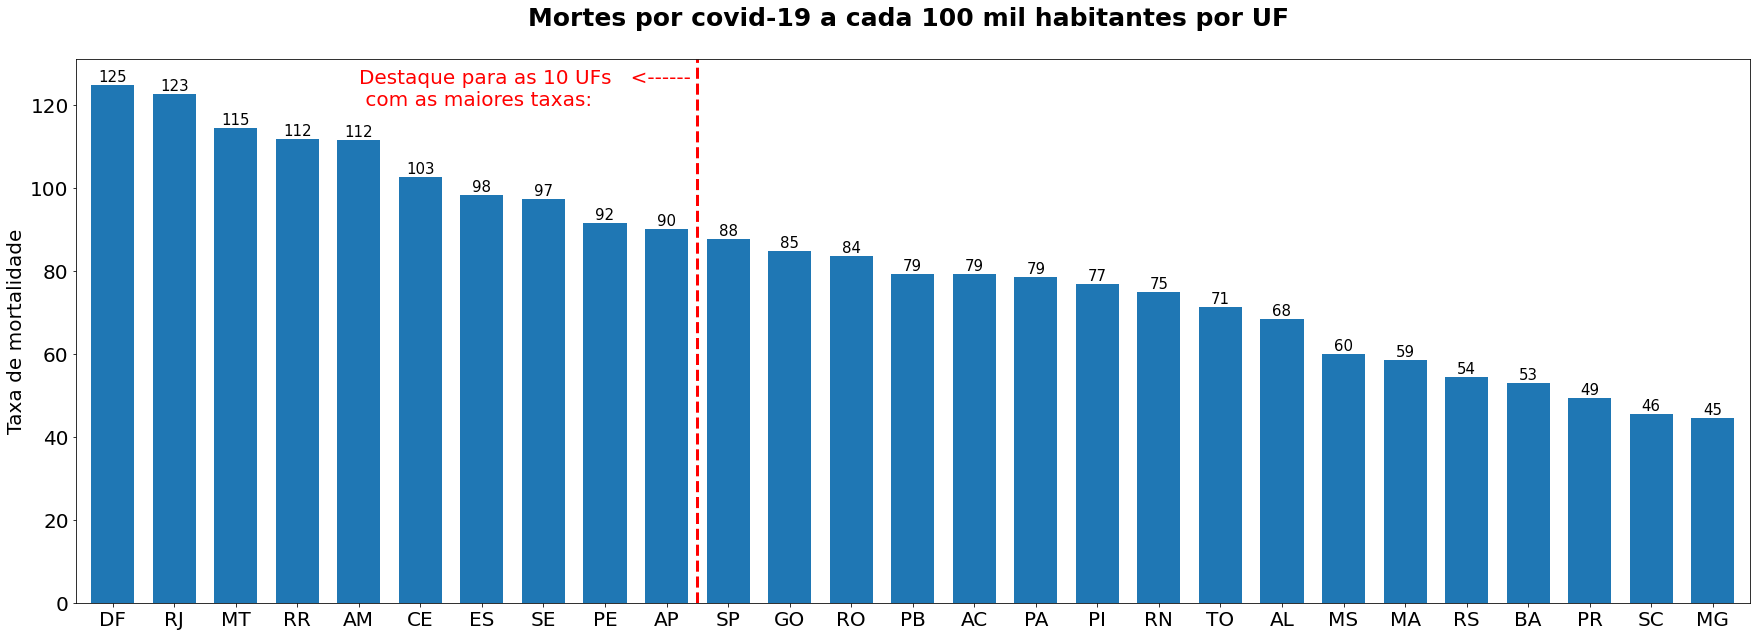

In [47]:
Figura_2 = plt.figure(figsize=(30, 10))
ax1 = Figura_2.add_subplot(111)

ordenado_mortes_100k_habitantes = ultimo_boletim_ind_UF_com_Gini_SUS_dens.sort_values('mortes_100k_hab',ascending = False)

ordenado_mortes_100k_habitantes.plot(y='mortes_100k_hab', ax=ax1, kind = 'bar', width=0.7, position=0.5, fontsize=20, figsize=(30,10),rot=0)

plt.title("Mortes por covid-19 a cada 100 mil habitantes por UF \n",fontsize=25, fontweight='bold')

ax1.set_ylabel('Taxa de mortalidade',fontsize=20)
ax1.set_xlabel("")

ax1.get_legend().remove()
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Para adição de linha vertical
ax1.axvline(9.5, color="red", linestyle="--", linewidth = 3)

# Rotina para adicionar os labels no próprio gráfico
for rect in ax1.patches:
    # Encontrar os valores de cada seção empilhada
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # A altura da barra é o valor do dado e é utilizado como o próprio label
    label_text = f'{height:.0f}'
    
    # Obtenção dos parâmetros para centralizar os labels
    label_x = x + width / 2
    label_y = y + height + 2

    # Para futuros reusos: a fim de evitar que fique texto residual, caso tenha algum valor = 0, ele não postará o label "0"  
    if height != 0:
      ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)


# Textos complementares no gráfico
plt.text(4, 120, "Destaque para as 10 UFs   <------ \n com as maiores taxas:",horizontalalignment='left',color=('red'),fontsize=20)

plt.show()

Após analisar a Figura 2 e o destaque das 10 UFs com as maiores taxas, faz-se uma pergunta: o que leva algumas UFs apresentarem valores tão diferentes? Tomemos como exemplo o DF e RJ que apresentam quase 3 vezes mais mortes por 100 mil habitantes do que SC e MG. 
<br>
Algumas hipóteses são levantadas:
<br>
* Seria a temperatura média? Considerando que o RJ apresenta altas temperaturas e observando UFs como AL, MA e BA, que também apresentam altas temperaturas, esta não parece ser uma boa correlação, visto os significativos menores valores de óbitos por 100 mil habitantes destas outras UFs. </font>
<br><br>
* Seria o clima litorâneo? O próprio DF já poderia ser suficiente para descartar tal hipótese. Ainda mais se observarmos UFs como RN, AL, MA e BA, cuja área litorânea ocupa significativa porção relativa de seus territórios e apresentam taxas de mortalidade bem inferiores ao RJ, definitivamente parece não ter qualquer correlação o fato de uma UF estar presente em litoral com a quantidade de mortes por covid-19.
<br><br>
* Seria o desempenho das medidas de *lockdown*? Há diversos estudos que apontam a eficácia do distanciamento social no combate à pandemia. Entretanto, não foram encontrados dados concretos e confiáveis das medidas de isolamento social promovidas por cada UF. Seria muito bom efetuar um estudo das medidas para poder entender melhor a eficácia do isolamento perante muitas outras medidas. Eis trabalho para um dia realizar.
<br><br>
* Seria a a prestação de serviço das unidades hospitalares do SUS? Considerando que mais de 70% da população brasileira depende exclusivamente do SUS (fonte: https://bvsms.saude.gov.br/bvs/pacsaude/diretrizes.php), de fato as diferenças no serviço prestado pode explicar tais discrepâncias. Para investigar isso pode-se utilizar diferentes abordagens, tais como quantidade de leitos disponíveis, respiradores, médicos, hospitais, distribuição geográfica de clínicas e hospitais, entre muitas outras variáveis. Nesta análise, vamos simplificar e considerar unicamente os **gastos totais nos procedimentos hospitalares do SUS nos últimos 2 anos por habitante**. Este estudo considera que os gastos por habitante nestes procedimentos hospitalares traz incorporado a quantidade de exames realizados, leitos existentes, respiradores disponíveis, médicos de plantão, hospitais e outros muitos detalhes que fazem a diferença no atendimento dos pacientes. Quanto mais e melhor a presença destes procedimentos hospitalares, mais custosa é a sua manutenção e, portanto, maior será o valor despendido por habitante.</font>
<br><br>
* Seria a densidade demográfica? A transmissão da covid-19 acontece de uma pessoa doente para outra por meio de aperto de mãos, gotículas de saliva,
espirro, tosse, objetos ou superfícies contaminadas, como celulares, mesas, maçanetas, brinquedos, teclados de computador, entre outros. Portanto, uma condição é necessária para o vírus se espalhar: proximadade entre as pessoas.  A densidade demográfica é um conceito populacional referente à média do número de pessoas residentes por unidade de área em uma dada localidade. Será investigada se para as UFs que lideram a quantidade mortes por 100 mil habitantes há alguma indicação de correlação com a **densidade demográfica**. </font>
<br><br>
* Seria a desigualdade de renda? Sabemos que a realidade socio-econômica dos brasileiros pode ser muito diferente. Há quem dependa do SUS exclusivamente (mais de 70% da população brasileira) e há quem possa pagar por diferentes médicos e ter acesso aos melhores hospitais, o que aumentam as possibilidades de sobrevivência. Considerando isso, também será investigada alguma correlação destas UFs que apresentam altas incidências de mortes por 100 mil habitantes com o **índice de Gini**, disponível no portal do IBGE; este índice é um importante indicador da desigualdade de renda e está disponível por UF.</font>

-- Mais sobre o índice (ou coeficiente) de Gini: "Medida de desigualdade relativa obtida a partir da Curva de Lorenz, que relaciona o percentual acumulado da população em ordem crescente de rendimentos (eixo x) e o percentual
acumulado de rendimentos (eixo y). Quando os percentuais acumulados de população correspondem aos percentuais acumulados de rendimentos (10% da população com 10% dos rendimentos, por exemplo),
tem-se a linha de perfeita igualdade. A Curva de Lorenz representa a
distribuição real de rendimentos de uma dada população tendo, em
geral, formato convexo. Quanto mais afastada da linha de perfeita
igualdade, mais desigual a distribuição. **O índice de Gini é uma medida
numérica que representa o afastamento de uma dada distribuição de renda (Curva de Lorenz) da linha de perfeita igualdade, variando de
“0” (situação onde não há desigualdade) e “1” (desigualdade máxima,
ou seja, toda a renda apropriada por um único indivíduo)"**</font>
<br>
Fonte: Síntese de Indicadores Sociais. Uma Análise das Condições de Vida. IBGE, 2018.</font>
<br>
</br>



# 3. Análise: Gastos totais nos procedimentos hospitales do SUS nos últimos 2 anos por habitante

A Figura 3 apresenta as UFs com maiores gastos totais nos procedimentos hospitalares do SUS nos últimos 2 anos divididos por habitante. Para a elaboração deste gráfico, foi consultada a base de dados disponível no DATASUS/TABNET (https://datasus.saude.gov.br/informacoes-de-saude-tabnet/), onde foram utilizados dados sobre Produção Hospitalar (SIH/SUS) por local de internação, a partir de 2008, por ano/mês de atendimento. Esta foi a mesma base de dados utilizada durante o módulo 1 do bootcamp de data science aplicada da Alura em Novembro de 2020.</font>
<br>

Abaixo da Figura 3 está um recorte da Figura 2, trazendo as 10 UFs com as maiores taxas de óbitos por covid-19 a cada 100 mil habitantes e destacando-se as UFs em comum com as 10 que menos gastaram com procedimentos hospitalares por habitante.

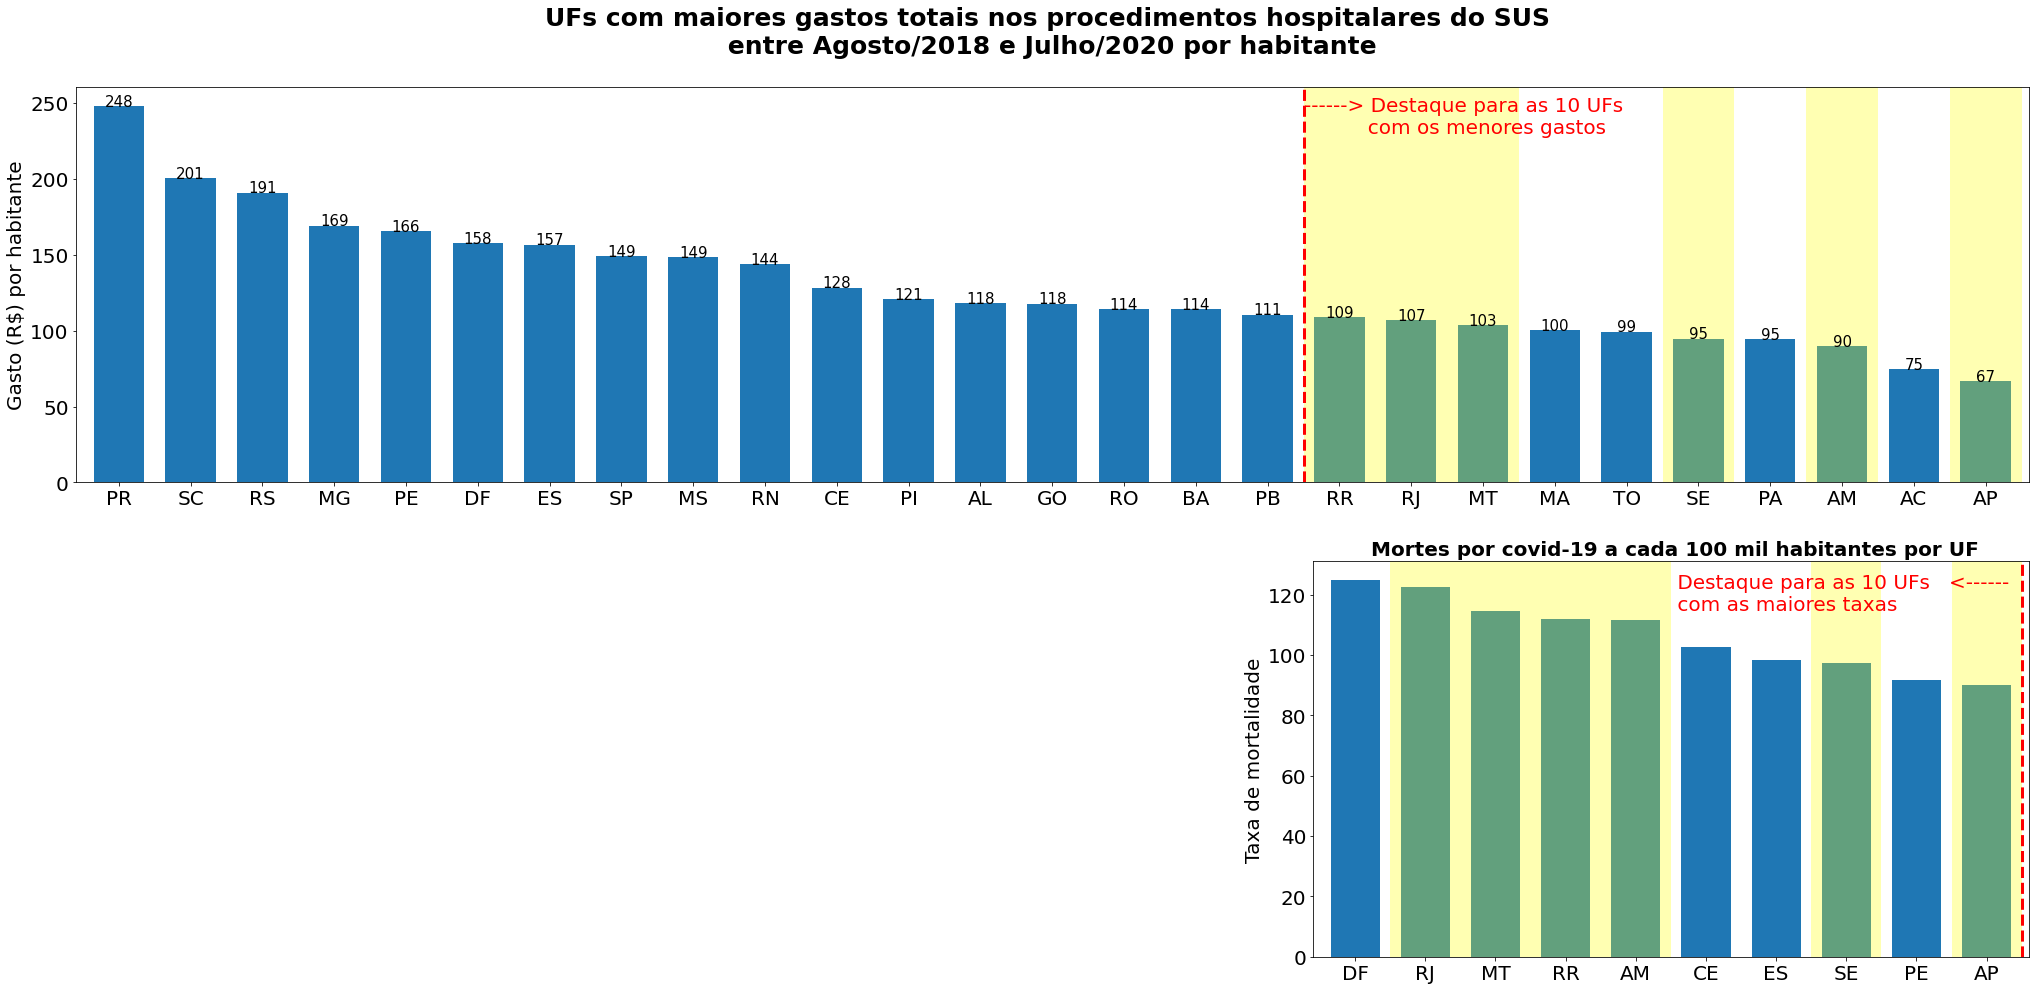

In [49]:
ordenado_gastos_SUS_habitante = ultimo_boletim_ind_UF_com_Gini_SUS_dens.sort_values('gastos_SUS_por_hab',ascending=False)

# Plot do gráfico
Figura_3 = plt.figure(figsize=(30,10))

#Primeiro gráfico pegando toda a largura
ax1 = Figura_3.add_subplot(2, 2, (1,2))

ordenado_gastos_SUS_habitante.plot(y = "gastos_SUS_por_hab", ax=ax1, kind = 'bar', width=0.7, position=0.5, fontsize=20,rot=0, figsize=(30, 10))

plt.title("UFs com maiores gastos totais nos procedimentos hospitalares do SUS \n entre Agosto/2018 e Julho/2020 por habitante \n",fontsize=25, fontweight='bold')

ax1.set_ylabel('Gasto (R$) por habitante',fontsize=20)
ax1.set_xlabel("")

# Remover a legenda
ax1.get_legend().remove()

# ALterar a formatação do eixo y
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Rotina para adicionar os labels no próprio gráfico
for rect in ax1.patches:
    # Encontrar os valores de cada seção empilhada
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # A altura da barra é o valor do dado e é utilizado como o próprio label
    label_text = f'{height:.0f}'
    
    # Obtenção dos parâmetros para centralizar os labels
    label_x = x + width / 2
    label_y = y + height + 3

    # Para futuros reusos: a fim de evitar que fique texto residual, caso tenha algum valor = 0, ele não postará o label "0"  
    if height != 0:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)


# Adicionar destaques amarelos para as UFs com menores gastos no SUS
ax1.add_patch(Rectangle((26 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((24 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((22 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((19 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((18 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((17 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))

# Para adição de linha vertical
ax1.axvline(16.5, color="red", linestyle="--", linewidth = 3)

# Textos complementares no gráfico
plt.text(16.5, 230, "------> Destaque para as 10 UFs\n          com os menores gastos",horizontalalignment='left',color=('red'),fontsize=20)


#####################################################

#Segundo gráfico pegando a porção inferior direita
ax2 = Figura_3.add_subplot(224)

#Jogar o mais pra baixo possível a figura de baixo (assim aumentar a distância entre elas)
ax2.set_aspect(0.043, anchor='SE')

ordenado_mortes_100k_habitantes.head(10).plot(y='mortes_100k_hab', ax=ax2, kind = 'bar', width=0.7, position=0.5, fontsize=20, figsize=(11,10),rot=0)

plt.title(" \n \n Mortes por covid-19 a cada 100 mil habitantes por UF",fontsize=20, fontweight='bold')

ax2.set_ylabel('Taxa de mortalidade',fontsize=20)
ax2.set_xlabel("")

ax2.get_legend().remove()
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Para adição de linha vertical
ax2.axvline(9.5, color="red", linestyle="--", linewidth = 3)

# Estte recorte de gráfico não terá os numeros sobre as colunas pois isso
# já foi feito no gráfico original

# Adicionar destaques amarelos para as UFs com menores gastos no SUS
ax2.add_patch(Rectangle((1 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((2 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((3 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((4 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((7 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((9 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))

# Textos complementares no gráfico
plt.text(4.5, 115, " Destaque para as 10 UFs   <------ \n com as maiores taxas",horizontalalignment='left',color=('red'),fontsize=20)

########################

# Ajustes da figura
Figura_3.set_figheight(16)
Figura_3.set_figwidth(35)


Existem 6 UFs em comum dentre as 10 com mais óbitos por covid-19 por 100 mil habitantes e as 10 que **menos** gastaram com procedimentos hospitalares nos últimos 2 anos.
<br>
Exposto isso, é natural surgir a seguinte pergunta: qual seria, numa amostra aleatória de 10 UFs, a probabilidade de existirem 6 UFs em comum com as destacadas na Figura 2 (maiores taxas de mortalidade)?
Afinal, dependendo da probabilidade (se for alta ou baixa), pode-se ter ou não um indicativo de possível correlação.
Para responder isso, devemos recorrer à estatística de análise combinatória.


Em uma amostra de 27 elementos (número de UFs), existem mais de 8 milhões de possibilidades de arranjos de 10 elementos, sem repetição e não importando a ordem: </font>

**$C_{27,10} = \frac{27!}{10!(27-10)!} = 8.436.285$**

Voltando à pergunta: quantos desses arranjos de 10 elementos possuem **quaisquer** 6 elementos que estão em comum com uma **outra** amostra pré especificada de 10 elementos ? </font>



Dada a complexidade do sistema de equações de análises combinatórias para estabelecer a correta probabilidade neste caso, é mais rápido e intuitivo obtermos esses valores utilizando-se programação puramente.
<br> <br>
O script abaixo gera todas as combinações agrupadas em 10 elementos entre 1 e 27 e, considerando uma lista pré especificada de 10 elementos (por exemplo de 1 a 10), ele calcula, para todas as combinações possíveis, a quantidade destes elementos que há em em comum para cada um destas combinações e armazena o resultado em uma lista, que por fim tem o mesmo tamanho da lista com as combinações (+ 8 milhões de linhas)

In [55]:
# Programa para gerar todas as combinações possíveis (sem troca e sem repetição)
lista_combo = []
num_correspondencia = []

# Biblioteca para trabalhar com combinações
from itertools import combinations 

# Todas as combinações de 27, em grupos de 10
combinacao = combinations([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                           16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],10) 
  
# Adicionar na lista "combo"
for i in list(combinacao): 
    lista_combo.append(i)

lista_dez_primeiros = [1,2,3,4,5,6,7,8,9,10]

# Varrer cada uma das +8 milhões de combinações
for i in lista_combo:
    qtde_em_comum = 0

# Caso a combinação em análise contenha algum elemento entre 1 e 10, soma-se um ponto
    for j in range (10):
        if lista_dez_primeiros[j] in i:
            qtde_em_comum = qtde_em_comum + 1

  # No final do laço, há a construção de uma lista paralela, com o número de pontos de
  # cada combinação.
    num_correspondencia.append(qtde_em_comum)

Para saber a quatidade de combinações que possuem em comum os elementos 1 a 6: 

In [62]:
num_correspondencia.count(6)

499800

Obviamente, só existe uma combinação possível de 10 elemennum_correspondencia.count(8)tos onde temos a presença de todos os 10 elementos investigados:

In [60]:
num_correspondencia.count(10)

1

Uma vez conhecendo-se a quantidade de elementos entre 1 a 10 em comum para cada combinação possível, é necessário calcular qual porcentagem dessas combinações possuem, pelo menos, 6 destes elementos em comum (pois foi esse o resultado obtido na Figura 3):

In [75]:
round(((num_correspondencia.count(10)+num_correspondencia.count(9)+num_correspondencia.count(8)+
        num_correspondencia.count(7)+num_correspondencia.count(6))/len(num_correspondencia))*100,2)

6.97

Verifica-se que há menos de **7%** de chances de obtermos 6 elementos em comum com outra amostra. <br>
<br>
Isso sugere que a ocorrência de 6 UFs em comum entre as 10 com as maiores taxas de mortabilidade por 100 mil habitantes e aquelas que menos receberam verbas por habitante para os procedimentos hospitaleres estão fora do acaso natural e, portanto, de alguma maneira elas pode apresentar alguma correlação. Um estudo mais detalhado a cerca da realidade das variáveis hospitalares (quantidade de leitos - incluindo os dos hospitais de campanha, respiradores e médicos por pacientes, além da disponibilidade de medicamentos, entre outras) é sugerido.

------------

Extra sobre análise combinatória: como curiosidade e para validar o experimento anterior, qual seria a quantidade e porcentagem de termos exatamente os 10 elementos dentre todas as +8 milhões de combinações possíveis? E o mesmo para pelo menos 1 elemento? </font>





In [68]:
qtde_10 = num_correspondencia.count(10)
porc_10 = (qtde_10/len(num_correspondencia))*100

print("Para os dez elementos em comum há apenas " + str(qtde_10) + " combinação")
print("Isso significa: " + str(qtde_10) + "/" + str(len(lista_combo)) + " = " + '{:.6f}'.format(porc_10) + "%")  

qtde_1_a_10 = (num_correspondencia.count(10)+num_correspondencia.count(9)+num_correspondencia.count(8)+num_correspondencia.count(7)+
        num_correspondencia.count(6)+num_correspondencia.count(5)+num_correspondencia.count(4)+num_correspondencia.count(3)+
        num_correspondencia.count(2)+num_correspondencia.count(1))

porc_1_a_10 = (qtde_1_a_10/len(num_correspondencia))*100

print("\nPara qualquer elemento (entre 1 e 10) em comum há " + str(qtde_1_a_10) + " combinações")
print("Isso significa: " + str(qtde_1_a_10) + "/" + str(len(lista_combo)) + " = " + '{:.2f}'.format(porc_1_a_10) + "%") 


Para os dez elementos em comum há apenas 1 combinação
Isso significa: 1/8436285 = 0.000012%

Para qualquer elemento (entre 1 e 10) em comum há 8416837 combinações
Isso significa: 8416837/8436285 = 99.77%


O valor de apenas uma combinação possível para exatamente os 10 elementos presentes num grupo qualquer de 10, dentre 27 elementos, é intuitivo: apenas uma e, portanto, representa uma probabilidade baixíssima.
<br> <br>
Já o valor 99,77% para a probabilidade de qualquer um dos 10 elementos presentes nas muitas combinações parece estar exagerado e talvez até ser contraintuitivo. Mas se calcularmos a quantidade de combinações possíveis entre 17 elementos (ou seja, isolando os 10 primeiros elementos e combinando apenas os elementos entre 11 e 27), sem repetição e não importando a ordem temos o seguinte valor:
</font>

$C_{27,10} = \frac{17!}{10!(17-10)!} = 19.448$

Este valor é exatamente o mesmo (como não poderia deixar de ser) da diferença entre todas as combinações e as combinações em que pelo menos um elemento é encontrado: 

In [67]:
print(str(len(lista_combo) - qtde_1_a_10))

19448


# 4. Análise: Índice de Gini (desigualdade de renda)

A seguir, será analisada a base de dados disponível no portal do IBGE chamada índice de Gini (explicado anteriormente), que mede a desigualdade de renda.
Como informação adicional, **quanto mais próximo de 1**, mais desigual é a renda naquela UF.</font>
<br>
A tabela a seguir traz os valores do índice de Gini desde o início de sua série histórica, em 2012.</font>

In [ ]:
df_gini_por_Estado.sort_index()

,2012,2013,2014,2015,2016,2017,2018,2019
Abertura_geografica,,,,,,,,
AC,0.511,0.504,0.476,0.497,0.501,0.494,0.501,0.497
AL,0.430,0.454,0.459,0.466,0.468,0.450,0.455,0.452
AM,0.530,0.528,0.509,0.500,0.516,0.552,0.495,0.514
AP,0.484,0.478,0.476,0.477,0.491,0.535,0.480,0.483
BA,0.549,0.528,0.526,0.507,0.511,0.565,0.524,0.533
CE,0.529,0.525,0.506,0.510,0.514,0.525,0.530,0.547
DF,0.572,0.563,0.543,0.560,0.543,0.563,0.544,0.551
ES,0.459,0.469,0.469,0.470,0.459,0.462,0.477,0.491
GO,0.460,0.454,0.437,0.436,0.426,0.453,0.443,0.429


A Figura 4a traz a variação destes valores graficamente. 






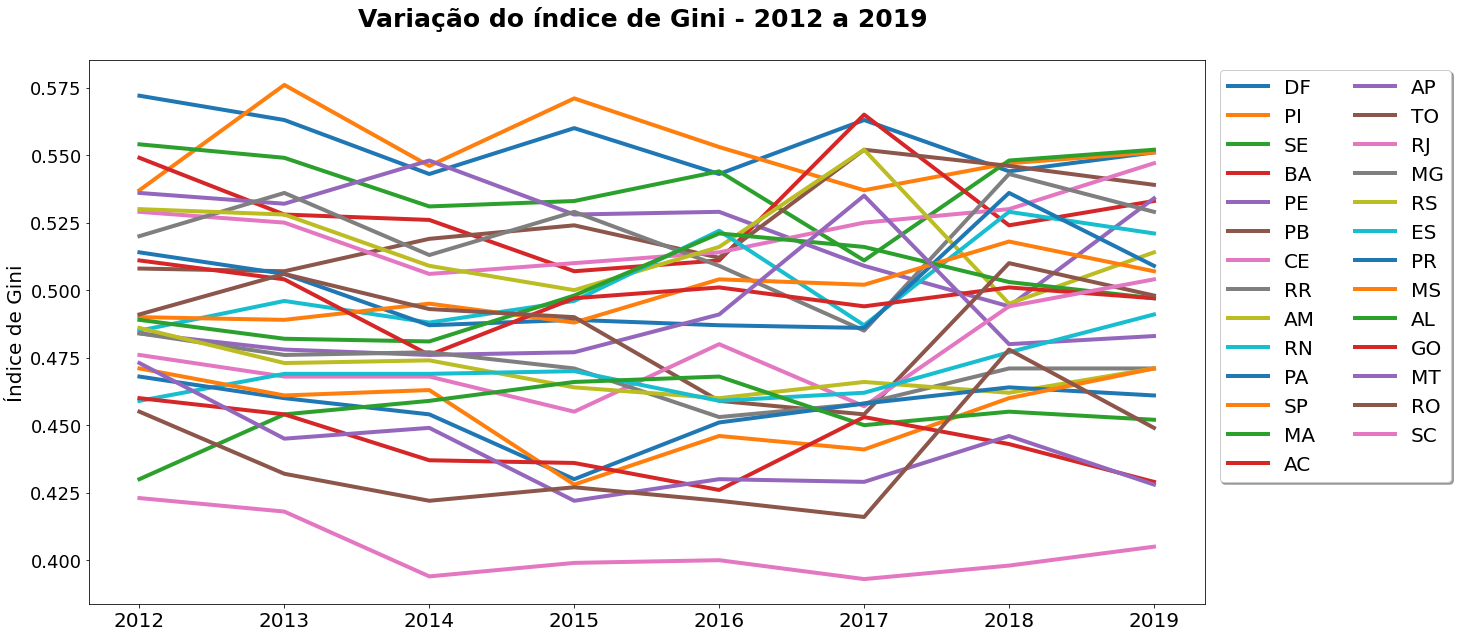

In [70]:
df_gini_por_Estado["Total"] = df_gini_por_Estado.sum(axis=1)
df_gini_por_Estado = df_gini_por_Estado.sort_values("Total",ascending=False)
df_gini_por_Estado = df_gini_por_Estado.drop("Total", axis = "columns")

Figura_4a, ax = plt.subplots(figsize=(20,10))
df_gini_por_Estado.T.plot(figsize=(20,10), linewidth=4, ax=ax)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.3f}"))
ax.set_title("Variação do índice de Gini - 2012 a 2019 \n", fontsize=25, fontweight='bold' )

ax.set_ylabel("Índice de Gini", fontsize=20)

# mudando o tamanho das fontes dos valores dos eixos
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)


plt.legend(loc = 'upper right', bbox_to_anchor=(1.23, 1), frameon = True, shadow = True, ncol=2, fontsize=20)
plt.show();


O gráfico da Figura 4a não apresenta fácil leitura pois há grandes quantidades de linhas que se sobrepõem umas às outras. Uma maneira de resumir a informação é somando a série histórica do índice de Gini e plotando em um gráfico de barras, por UF.
<br><br>
Esta soma da série histórica é importante pois a desigualdade de renda, embora apresentada na forma de um indicador anual, diz sobre o passado e o futuro a curto prazo de uma sociedade. Por exemplo, uma alta desigualdade de renda, que pode resultar em piores condições de trabalho para todos, talvez apresente melhores indicadores da desigualdade de renda em anos seguintes, o que não significa necessariamente que as condições de vida melhoraram, mas sim que a renda (que foi degradada) ficou menos desigual, possivelmente com aumento da fatia da população dos mais vulneráveis socio-economicamente.
<br><br>
Portanto, ao levarmos em consideração o histórico da desigualdade de renda, estamos entendendo melhor a história desse indicador de uma UF específica.</font>
<br><br>
A Figura 4b apresenta o gráfico de barras mencionado anteriormente. Novamente, são destacadas as UFs que estão dentre as 10 mais desiguais na série histórica e que também apresentam as 10 maiores taxas de óbitos por covid-19 a cada 100 mil habitantes, como pode ser visto no recorte da Figura 2 presente logo abaixo.</font>




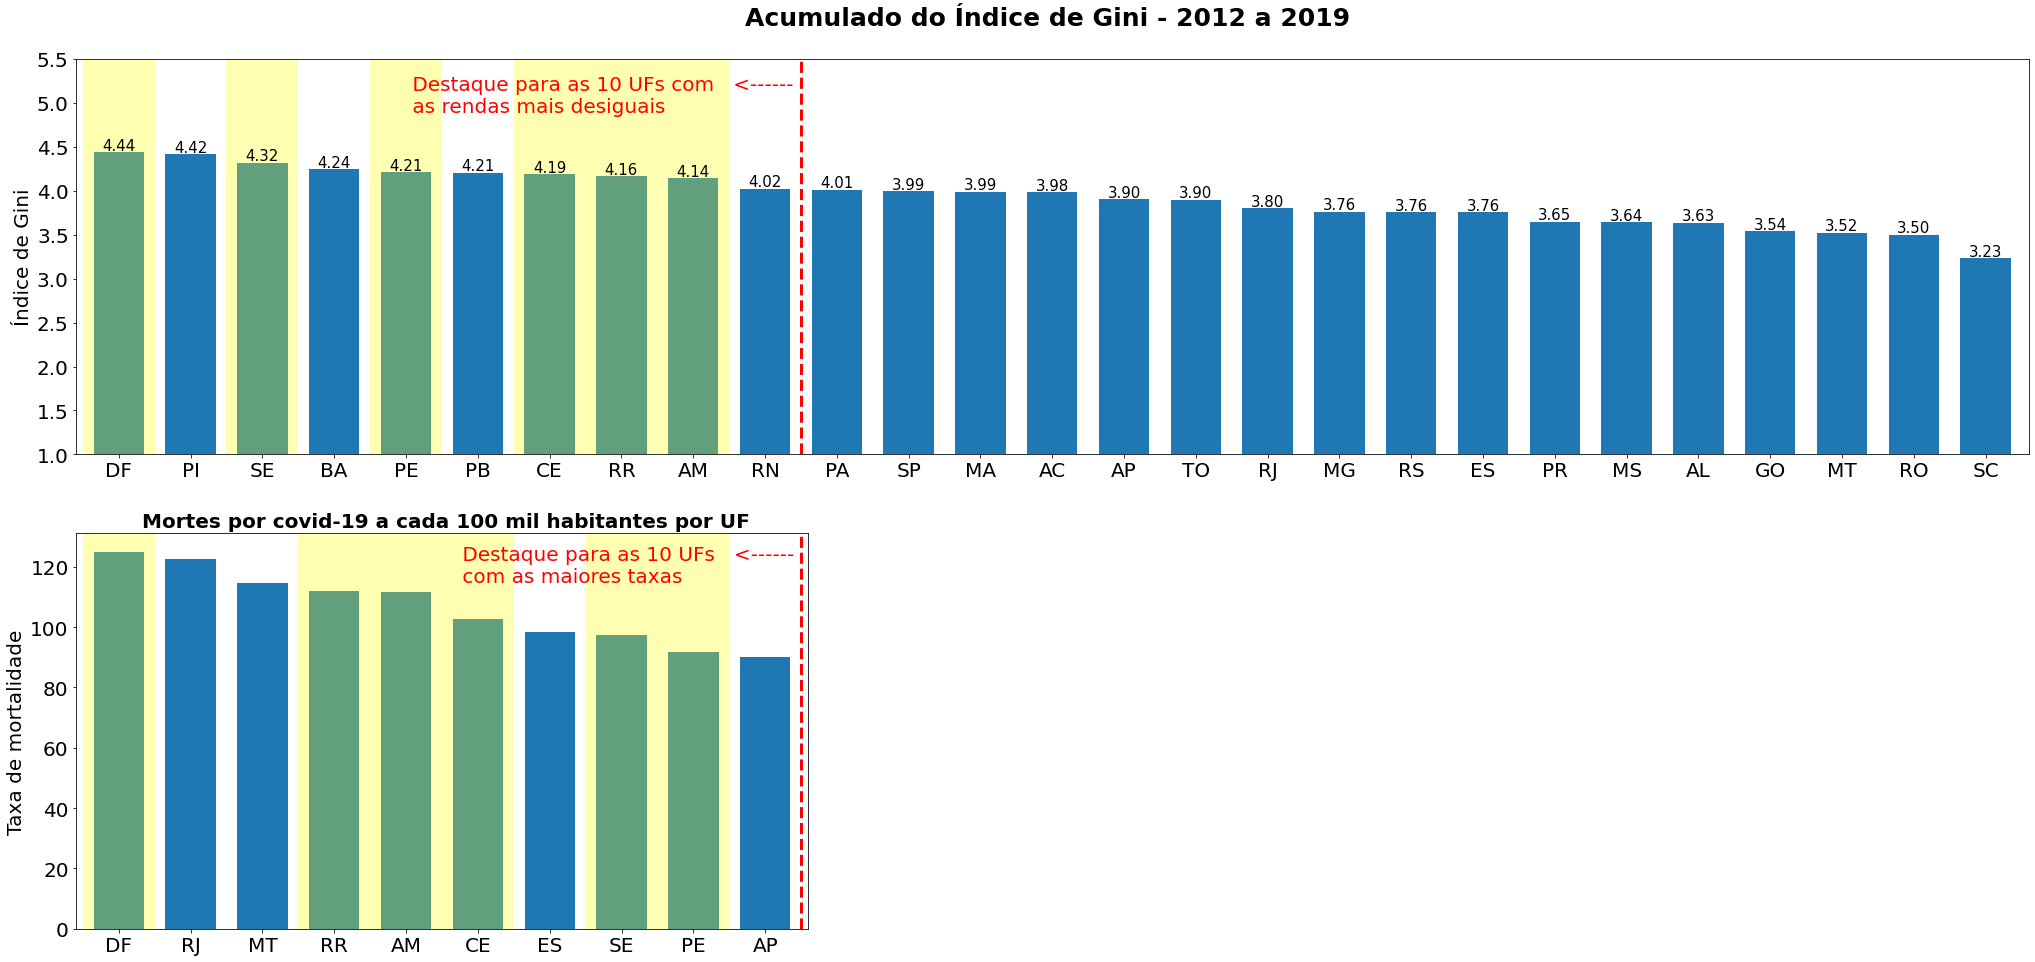

In [71]:
# Copiar o dataframe com .copy para ter ids diferentes na memória
df_gini_por_Estado_Total = df_gini_por_Estado.copy()
df_gini_por_Estado_Total["Total"] = df_gini_por_Estado.sum(axis=1)
df_gini_por_Estado_Total

# Plot do gráfico
Figura_4b = plt.figure(figsize=(30,10))

#Primeiro gráfico pegando toda a largura
ax1 = Figura_4b.add_subplot(2, 2, (1,2))

df_gini_por_Estado_Total.plot(y='Total', ax=ax1, kind = 'bar', width=0.7, position=0.5, fontsize=20, figsize=(30,10),rot=0)

ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1f}"))
ax1.set_title("Acumulado do Índice de Gini - 2012 a 2019 \n", fontsize=25, fontweight='bold' )

ax1.set_ylabel("Índice de Gini", fontsize=20)
ax1.set_xlabel("")

ax1.set_ylim(1,5.5)

# mudando o tamanho das fontes dos valores dos eixos
plt.xticks(fontsize=20)

plt.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1), frameon = True, shadow = True, ncol=2, fontsize=20)

ax1.get_legend().remove()

# Rotina para adicionar os labels no próprio gráfico
for rect in ax1.patches:
    # Encontrar os valores de cada seção empilhada
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # A altura da barra é o valor do dado e é utilizado como o próprio label
    label_text = f'{height:.2f}'
    
    # Obtenção dos parâmetros para centralizar os labels
    label_x = x + width / 2
    label_y = y + height + 0.08

    # Para futuros reusos: a fim de evitar que fique texto residual, caso tenha algum valor = 0, ele não postará o label "0"  
    if height != 0:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)

# Adicionar destaques amarelos para as UFs com menores gastos no SUS
ax1.add_patch(Rectangle((0 - .5, 0 - .5), 1, 10, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((7 - .5, 0 - .5), 1, 10, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((8 - .5, 0 - .5), 1, 10, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((6 - .5, 0 - .5), 1, 10, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((2 - .5, 0 - .5), 1, 10, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((4 - .5, 0 - .5), 1, 10, facecolor="yellow",alpha=0.3))

# Para adição de linha vertical
ax1.axvline(9.5, color="red", linestyle="--", linewidth = 3)

# Textos complementares no gráfico
plt.text(4, 4.9, " Destaque para as 10 UFs com   <------ \n as rendas mais desiguais",horizontalalignment='left',color=('red'),fontsize=20)


#####################################################

#Segundo gráfico pegando a porção inferior direita
ax2 = Figura_4b.add_subplot(223)

#Jogar o mais pra baixo possível a figura de baixo (assim aumentar a distância entre elas)
ax2.set_aspect(0.042, anchor='SW')

ordenado_mortes_100k_habitantes.head(10).plot(y='mortes_100k_hab', ax=ax2, kind = 'bar', width=0.7, position=0.5, fontsize=20, figsize=(11,10),rot=0)

plt.title(" \n \n Mortes por covid-19 a cada 100 mil habitantes por UF",fontsize=20, fontweight='bold')

ax2.set_ylabel('Taxa de mortalidade',fontsize=20)
ax2.set_xlabel("")

ax2.get_legend().remove()
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Para adição de linha vertical
ax2.axvline(9.5, color="red", linestyle="--", linewidth = 3)

# Estte recorte de gráfico não terá os numeros sobre as colunas pois isso
# já foi feito no gráfico original

# Adicionar destaques amarelos para as UFs com menores gastos no SUS
ax2.add_patch(Rectangle((0 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((3 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((4 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((5 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((7 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((8 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))

# Textos complementares no gráfico
plt.text(4.7, 115, " Destaque para as 10 UFs   <------ \n com as maiores taxas",horizontalalignment='left',color=('red'),fontsize=20)

########################

# Ajustes da figura
Figura_4b.set_figheight(16)
Figura_4b.set_figwidth(35)

Também observa-se a presença de 6 UFs em comum com as 10 que apresentam as maiores quantidades de óbitos por 100 mil habitantes.</font>
<br> <br>
Novamente, assim como ocorreu na análise anterior, há indicação de possível correlação entre esses indicadores, afinal a probabilidade disso ter ocorrido, ao acaso, seria menos de 7%. Assim, sugere-se um estudo detalhado em um momento oportuno envolvendo a realidade da população residente nas UFs que apresentam as maiores rendas desiguais (acesso ao transporte público, local da jornada de trabalho, acesso a hospitais privados, medicamentos, saneamento básico, entre outros fatores) e verificar se possuem alguma relação com as altas taxas de óbitos por covid-19 a cada 100 mil habitantes 




A preocupação da consequência da desigualdade de renda no impacto de uma pandemia também é assunto deste artigo: "Desigualdade econômica e risco de infecção e morte por COVID-19 no Brasil", 10/2020. </font> <br> (disponível em https://www.scielo.br/scielo.php?pid=S1415-790X2020000100209&script=sci_arttext#B26)

# 5. Análise: Densidade demográfica

Por fim, é analisado se a densidade demográfica também sugere alguma correlação com os óbitos da covid-19 por 100 mil habitantes. Os valores da densidade demográfica por UF estão disponíveis no portal do IBGE (https://www.ibge.gov.br/cidades-e-estados), em diversos formatos de arquivos para baixar.

Os últimos valores oficiais datam de 2010, mas como há a informação da área de cada UF e também da projeção populacional para 2020, foi feita uma projeção da densidade demográfica em 2020 (Figura 5); logo abaixo, há o recorte da Figura 2, que mostra a taxa de mortalidade a cada 100 mil habitantes.


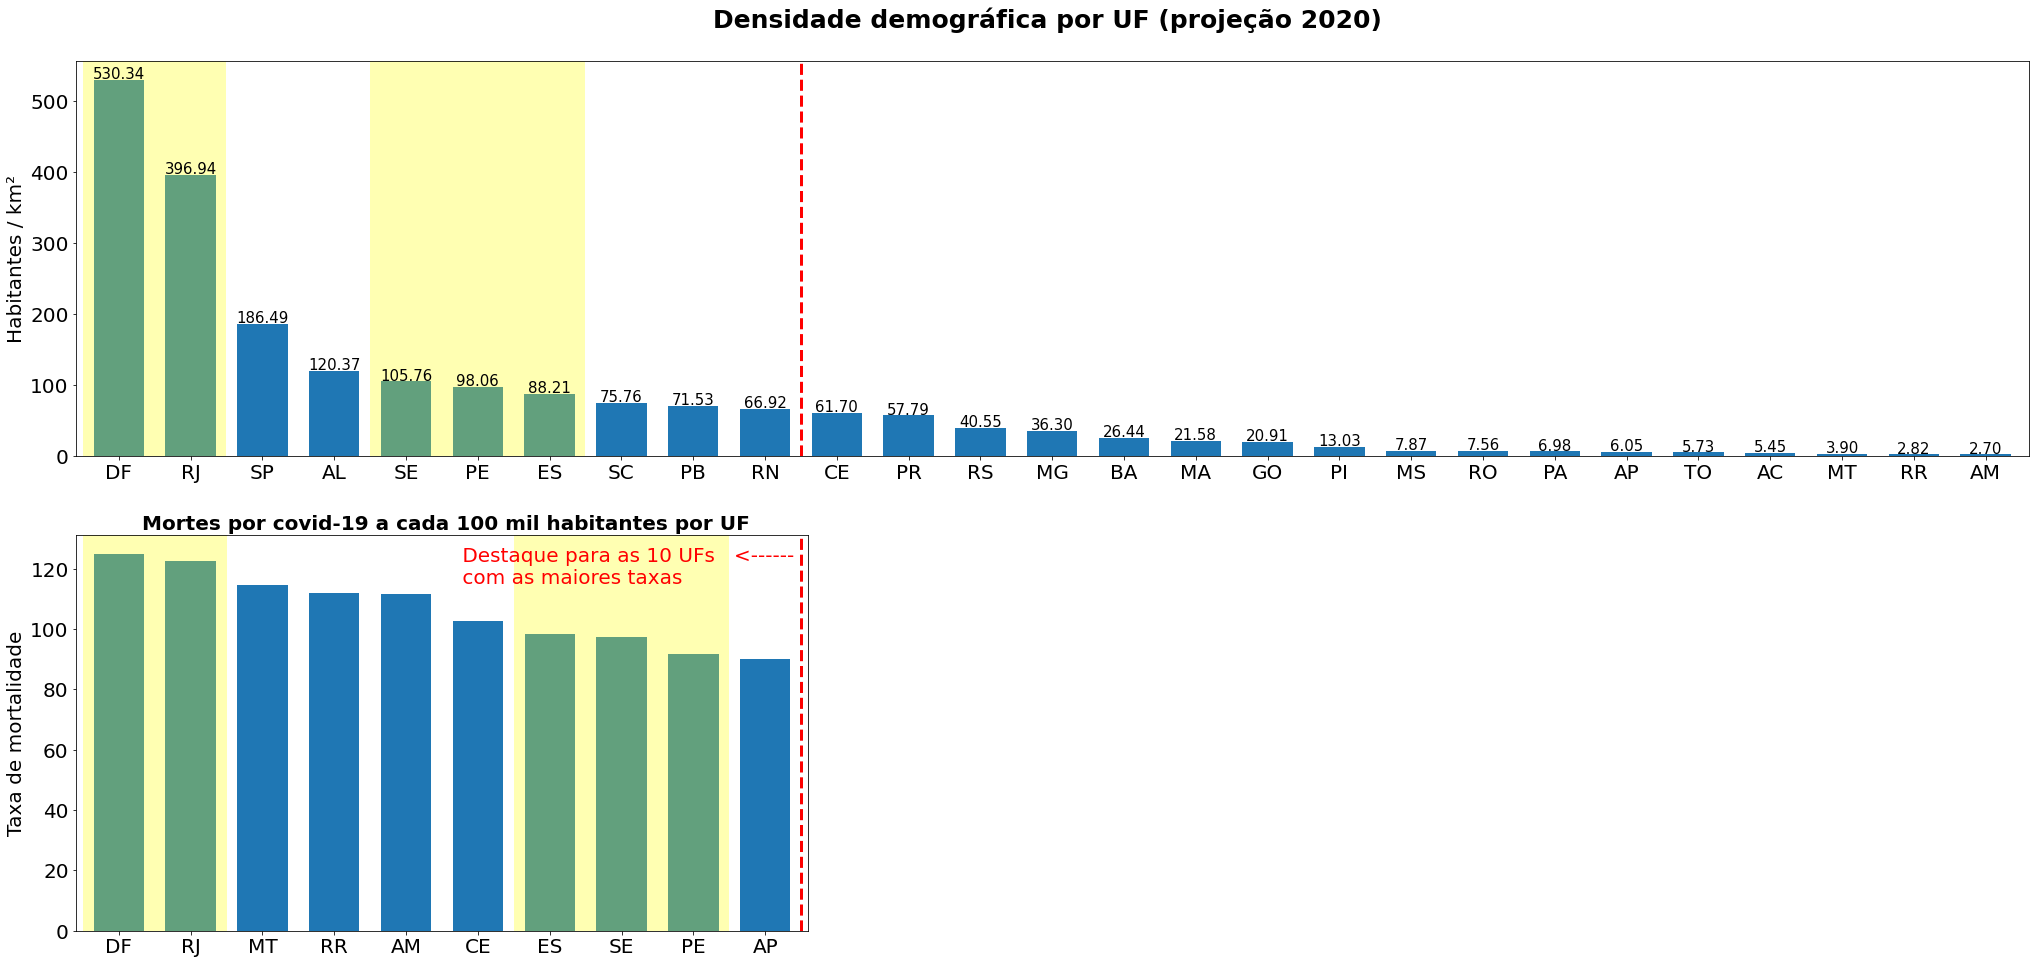

In [73]:
# Plot do gráfico
Figura_5 = plt.figure(figsize=(30,10))

#Primeiro gráfico pegando toda a largura
ax1 = Figura_5.add_subplot(2, 2, (1,2))

df_densidade_demografica_por_Estado.plot(x='UF', y='dens_demografica_hab_km2_2020', ax=ax1, kind = 'bar', width=0.7, position=0.5, fontsize=20, figsize=(30,10),rot=0)

plt.title("Densidade demográfica por UF (projeção 2020) \n",fontsize=25, fontweight='bold')

ax1.set_ylabel('Habitantes / km²',fontsize=20)
ax1.set_xlabel("")

ax1.get_legend().remove()
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Rotina para adicionar os labels no próprio gráfico
for rect in ax1.patches:
    # Encontrar os valores de cada seção empilhada
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # A altura da barra é o valor do dado e é utilizado como o próprio label
    label_text = f'{height:.2f}'
    
    # Obtenção dos parâmetros para centralizar os labels
    label_x = x + width / 2
    label_y = y + height + 8

    # Para futuros reusos: a fim de evitar que fique texto residual, caso tenha algum valor = 0, ele não postará o label "0"  
    if height != 0:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)

# Adicionar destaques amarelos para as UFs com menores gastos no SUS
ax1.add_patch(Rectangle((0 - .5, 0 - .5), 1, 700, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((1 - .5, 0 - .5), 1, 700, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((4 - .5, 0 - .5), 1, 700, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((5 - .5, 0 - .5), 1, 700, facecolor="yellow",alpha=0.3))
ax1.add_patch(Rectangle((6 - .5, 0 - .5), 1, 700, facecolor="yellow",alpha=0.3))

# Para adição de linha vertical
ax1.axvline(9.5, color="red", linestyle="--", linewidth = 3)

#####################################################

#Segundo gráfico pegando a porção inferior direita
ax2 = Figura_5.add_subplot(223)

#Jogar o mais pra baixo possível a figura de baixo (assim aumentar a distância entre elas)
ax2.set_aspect(0.042, anchor='SW')

ordenado_mortes_100k_habitantes.head(10).plot(y='mortes_100k_hab', ax=ax2, kind = 'bar', width=0.7, position=0.5, fontsize=20, figsize=(11,10),rot=0)

plt.title(" \n \n Mortes por covid-19 a cada 100 mil habitantes por UF",fontsize=20, fontweight='bold')

ax2.set_ylabel('Taxa de mortalidade',fontsize=20)
ax2.set_xlabel("")

ax2.get_legend().remove()
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Para adição de linha vertical
ax2.axvline(9.5, color="red", linestyle="--", linewidth = 3)

# Estte recorte de gráfico não terá os numeros sobre as colunas pois isso
# já foi feito no gráfico original

# Adicionar destaques amarelos para as UFs com menores gastos no SUS
ax2.add_patch(Rectangle((0 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((1 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((7 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((8 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))
ax2.add_patch(Rectangle((6 - .5, 0 - .5), 1, 300, facecolor="yellow",alpha=0.3))

# Textos complementares no gráfico
plt.text(4.7, 115, " Destaque para as 10 UFs   <------ \n com as maiores taxas",horizontalalignment='left',color=('red'),fontsize=20)

########################

# Ajustes da figura
Figura_5.set_figheight(16)
Figura_5.set_figwidth(35)

Primeiramente, nota-se que há 3 UFs (DF, RJ e SP) que possuem densidade demográfica bastante superior em relação às demais UFs.<br><br>
Além disso, conforme pode ser observado, há 5 UFs que estão entre as 10 mais densamente povoadas e que apresentam os maiores números de óbitos por covid-19 a cada 100 mil habitantes.<br><br>
Aplicando-se o mesmo raciocinio da primeira análise, porém para calcularmos a probabilidade ao acaso de termos 5 UFs aleatórias e em comum com as 10 UFs que possuem as maiores taxas de mortalidade, chega-se ao valor de pouco mais de 25% (vide Extra 2, abaixo). Aparentemente a correlação é mais fraca do que a encontrada para os investimentos hospitalares e desigualdade de renda. Entretanto, destaca-se que as 2 UFs mais densamente povoadas (DF e RJ) também são as 2 primeiras em taxas de mortalidade. E a UF de SP é a 11º UF com mais mortes por covid-19 a cada 100 mil habitantes (vide Figura 2).<br><br>
Ressalta-se aqui que a densidade demográfica é uma variável que se comporta de maneira bem distante entre diferentes regiões de uma cidade e estado. Sugere-se um estudo por regiões, principalmente nas cidades de Brasília, Rio de Janeiro e São Paulo, que concentram grande parte dos óbitos de suas UFs para entender melhor como a densidade demográfica pode afetar a taxa de transmissão do vírus. Será que há um valor-limite para a densidade demográfica abaixo do qual a taxa de transmissão é significativamente menor? Se comprovado a existência de tal valor-limite, para futuras pandemias, as ações podem ser intensificadas para regiões com densidade demográfica acima deste limite.
<br><br>
Após esta terceira análise, notamos que a UF do Sergipe é a única que esteve presente em todas elas.


-------------

Extra (2) sobre análise combinatória: qual a probabilidade de termos 5 elementos (de 10 possíveis) em comum com uma amostra aleatória de 10 elementos? A resposta é pouco mais de 25%, conforme mostrado abaixo</font>


In [76]:
round(((num_correspondencia.count(10)+num_correspondencia.count(9)+num_correspondencia.count(8)+
        num_correspondencia.count(7)+num_correspondencia.count(6)+num_correspondencia.count(5))/len(num_correspondencia))*100,2)

25.45

# 6. Conclusões
Neste trabalho buscou-se inspirar pesquisadores para identificar possíveis correlações de 3 diferentes indicadores em relação aos números de óbitos de covid-19 por 100 mil habitantes nas diferentes UFs do Brasil. O primeiro, relativo ao custo da prestação de serviço nas unidades hospitalares do SUS nos últimos anos, mostrou-se bem provável. O segundo, relativo a desigualdade de renda, também foi identificado como provável. Por fim, o terceiro, que foi o estudo da densidade demográfica, a princípio é menos provável que os 2 primeiros mas que merece bastante atenção por se tratar de um valor que oscila muito a depender da região da UF. Para todas as análises foram sugeridos trabalhos complementares e futuros.

Em particular, chamou a atenção a UF do Sergipe ser a única presente nas 3 análises, ou seja, ela está dentre as:
* 10 UFs com as maiores taxas de óbitos por 100 mil habitantes;
* 10 UFs que menos gastaram com procedimentos hospitalares nos últimos 2 anos;
* 10 UFs mais desiguais em renda;
* 10 UFs mais densamente povoadas.

Sugere-se, então, um estudo dedicado à realidade do Sergipe para levantar prioridades de investimentos na saúde pública (por exemplo: na realização de exames, contratação de médicos, reforma e construção de hospitais, obtenção de medicamentos, priorização na futura campanha de vacinação, entre outras possibilidades) a fim de diminuir o impacto desta e de outras pandemias. <br><br>
Por fim, não se pode ignorar o efeito das medidas de isolamento social que foram promovidas diferentemente por UF. Não foram encontrados dados concisos sobre as medidas tomadas. Mas existem muitas informações que pouco a pouco estão sendo coletadas, por exemplo a data de paralisação dos eventos, o tipo de pronunciamentos (a favor ou contra isolamento) dos governadores, entre outras. <br><br>
Certamente veremos estudos  desta natureza muito em breve que podem ajudar a desvendar as razões pelas quais algumas UFs possuem taxas de mortalidade por 100 mil habitantes tão diferentes entre si.